In [1]:
#Source: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#sphx-glr-download-advanced-neural-style-tutorial-py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
imsize = 512 if torch.cuda.is_available() else 128 

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.ToTensor()])  


def image_loader(image_name):
    image = Image.open(image_name)
    
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/wave.jpg") #city2.jpg, ocean2.jpg, wave.jpg
content_img = image_loader("./images/landwaste.jpg") #ocean.jpg, city3.jpg, landwaste.jpg

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

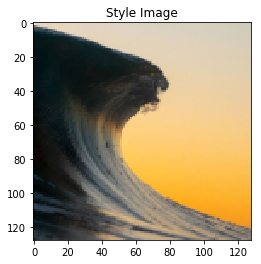

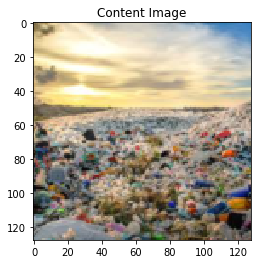

In [5]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    
    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t())  

   
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
content_layers_default = ['conv_6']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    
    content_losses = []
    style_losses = []

    
    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

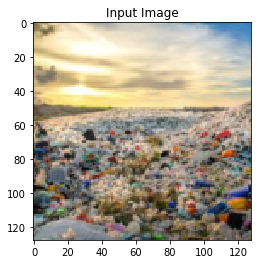

In [12]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [13]:
def get_input_optimizer(input_img):
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=9000, content_weight=1): #style_weight=1000000
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 100
            content_score = 100

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 25 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/miniconda3/envs/art185ai/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/miniconda3/envs/art185ai/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Optimizing..
run [25]:
Style Loss : 900032.062500 Content Loss: 131.203613

run [50]:
Style Loss : 900021.812500 Content Loss: 130.577286

run [75]:
Style Loss : 900018.562500 Content Loss: 130.288895

run [100]:
Style Loss : 900017.500000 Content Loss: 130.116135

run [125]:
Style Loss : 900016.812500 Content Loss: 130.026611

run [150]:
Style Loss : 900016.187500 Content Loss: 129.972321

run [175]:
Style Loss : 900016.000000 Content Loss: 129.840622

run [200]:
Style Loss : 900015.812500 Content Loss: 129.791306

run [225]:
Style Loss : 900015.562500 Content Loss: 129.751312

run [250]:
Style Loss : 900015.437500 Content Loss: 129.728302

run [275]:
Style Loss : 900015.312500 Content Loss: 129.719437

run [300]:
Style Loss : 900015.187500 Content Loss: 129.693802



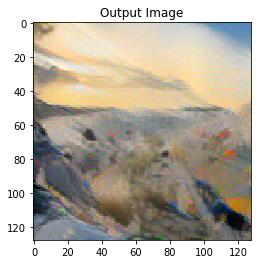

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()